In [1]:
import pulse2percept as p2p
import numpy as np
import cv2

# logo = p2p.stimuli.LogoBVL()
# print(logo)
image = p2p.stimuli.ImageStimulus('man-beard-eyes-person.jpg')
print(image)

ImageStimulus(data=<(3431610, 1) np.ndarray>, dt=0.001, 
              electrodes=<(3431610,) np.ndarray>, 
              img_shape=(1257, 910, 3), 
              is_charge_balanced=False, metadata=dict, 
              shape=(3431610, 1), time=None)


## Preprocessing an image

:py:class:`~pulse2percept.stimuli.ImageStimulus` objects come with a number
of methods to process an image before it is passed to an implant. We can:

-  :py:meth:`~pulse2percept.stimuli.ImageStimulus.trim` any black borders
   around the image.
-  :py:meth:`~pulse2percept.stimuli.ImageStimulus.threshold` the image using
   a number of commonly used techniques (e.g., Otsu's method, adaptive
   thresholding, ISODATA),
-  :py:meth:`~pulse2percept.stimuli.ImageStimulus.filter` the image and
   extract edges (e.g., Sobel, Scharr, Canny, median filter),
-  :py:meth:`~pulse2percept.stimuli.ImageStimulus.apply` any input-output
   function not covered above (must accept an image as input and return
   another image of the same size).


Let's look at a concrete example.
To get the BVL logo into proper shape, we need to convert the 4-channel RGBA
image to grayscale. This can be done with
:py:meth:`~pulse2percept.stimuli.ImageStimulus.rgb2gray`.
In addition, since grayscale values will be mapped to current ampltiudes,
we may want to :py:meth:`~pulse2percept.stimuli.ImageStimulus.invert` the
image so that image edges appear bright on a dark background.


## no difference if applied inversion first or grayscale first

<Axes: >

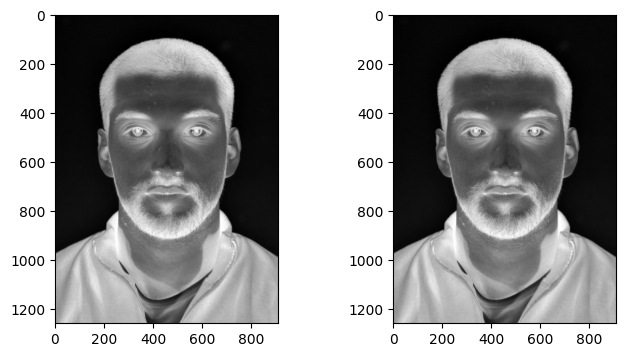

In [2]:
image_invert_gray = image.invert().rgb2gray()
image_gray = image.rgb2gray()
image_gray_invert = image_gray.invert()

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
image_invert_gray.plot(ax=ax1)
image_gray_invert.plot(ax=ax2)

<Axes: >

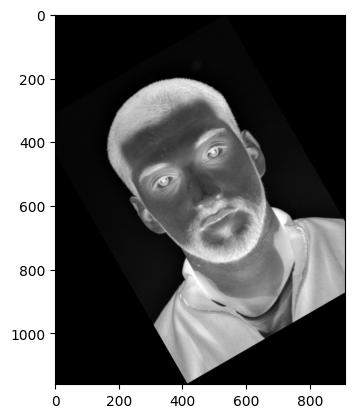

In [4]:
image_gray.scale(0.75).rotate(30).trim().plot()

As mentioned in the introduction above, the
:py:meth:`~pulse2percept.stimuli.ImageStimulus.filter` method provides
a number of popular techniques to extract edges from the image, such as:

-  ``'sobel'`` to extract edges using the [Sobel operator](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.sobel),
-  ``'scharr'`` to extract edges using the [Scharr operator](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.scharr),
   and
-  ``'canny'`` to extract edges using the [Canny algorithm](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny).

Additional parameters (e.g., the standard deviation of the Gaussian filter
for the Canny algorithm) can be passed as keyword arguments (e.g.,
``filter('canny', sigma=3)``).

For example, we can use the Scharr operator as follows:



## different quantization

<Axes: >

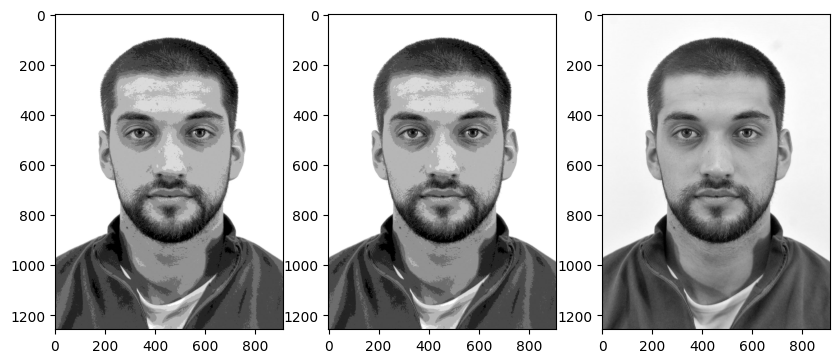

In [5]:
cv_image = cv2.imread('man-beard-eyes-person.jpg', cv2.IMREAD_GRAYSCALE)

quantized_image = (cv_image // 32) * 32

# Convert the quantized image to a p2p ImageStimulus
quantized_image = p2p.stimuli.ImageStimulus(quantized_image)


# plot the quantized image
p2p_image = p2p.stimuli.ImageStimulus(cv_image)

# Fix: ImageStimulus works with normalized values (0-1), so we need to adjust our quantization
# Quantize to 8 levels: map 0-1 range to 8 discrete levels
def quantize_to_8_levels(x):
    # x is in range [0, 1] for ImageStimulus
    # Map to 8 levels: 0, 1/7, 2/7, 3/7, 4/7, 5/7, 6/7, 1
    quantized = np.floor(x * 8) / 7  # This gives us 8 levels from 0 to 7/7
    return np.clip(quantized, 0, 1)  # Ensure we stay in [0,1] range

quantized_image_enhance = p2p_image.apply(quantize_to_8_levels)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 6))
quantized_image.plot(ax=ax1) #, title='Original'
quantized_image_enhance.plot(ax=ax2)    # title='8-Level Quantized')
image_gray.plot(ax=ax3) #, title='P2P Grayscale')

<Axes: >

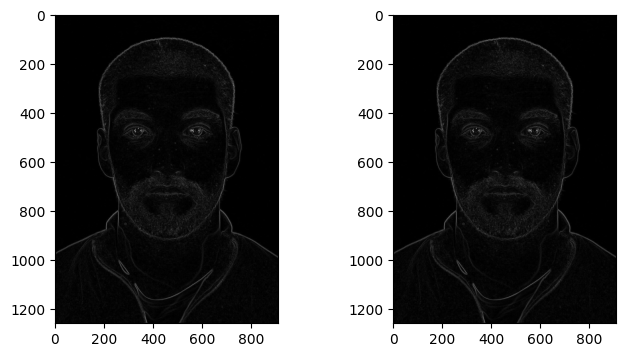

In [7]:
logo_edge = image_gray.filter('scharr')
image_edge_invert = image_gray_invert.filter('scharr')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
logo_edge.plot(ax=ax1)
image_edge_invert.plot(ax=ax2)

## from gray to edges

<Axes: >

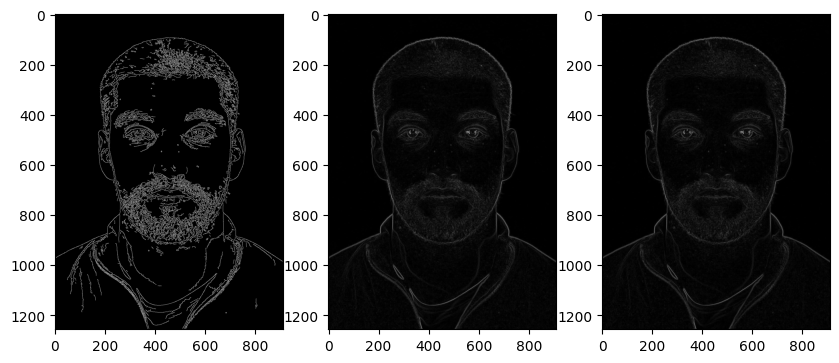

In [8]:
# show different types of filters
canny = image_gray.filter('canny', sigma=1)
sobel = image_gray.filter('sobel')
scharr = image_gray.filter('scharr')

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 6))
canny.plot(ax=ax1)
sobel.plot(ax=ax2)
scharr.plot(ax=ax3)

<Axes: >

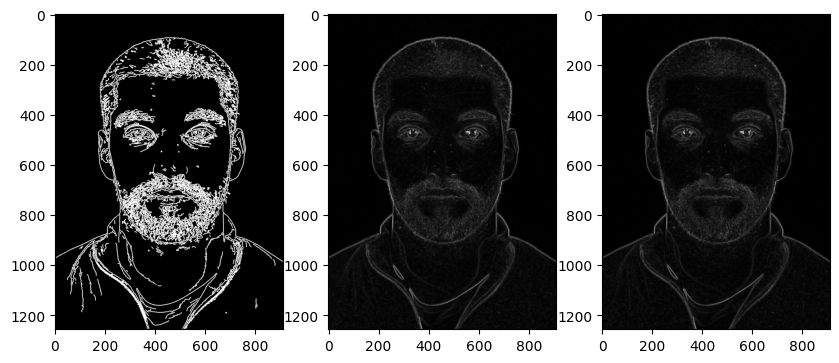

In [9]:
from skimage.morphology import dilation

# Apply dilation to the edge-detected image
dilated_canny = canny.apply(dilation)
dilated_sobel = sobel.apply(dilation)
dilated_scharr = scharr.apply(dilation)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 6))
dilated_canny.plot(ax=ax1)
dilated_sobel.plot(ax=ax2)
dilated_scharr.plot(ax=ax3)

## from quantized to edges

<Axes: >

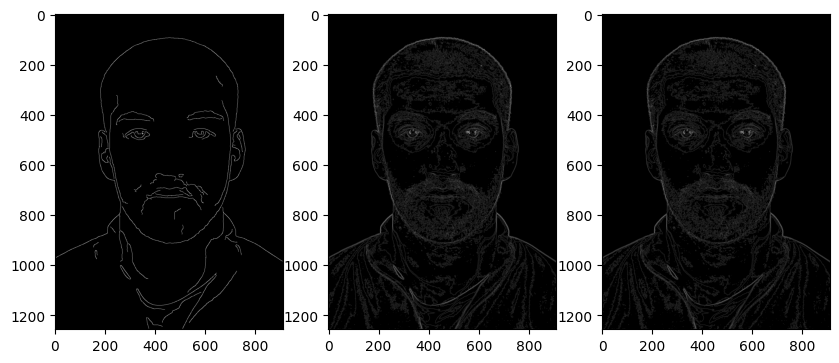

In [10]:
# show different types of filters
quant_canny = quantized_image.filter('canny', sigma=3)
quant_sobel = quantized_image.filter('sobel')
quant_scharr = quantized_image.filter('scharr')

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 6))
quant_canny.plot(ax=ax1)
quant_sobel.plot(ax=ax2)
quant_scharr.plot(ax=ax3)

<Axes: >

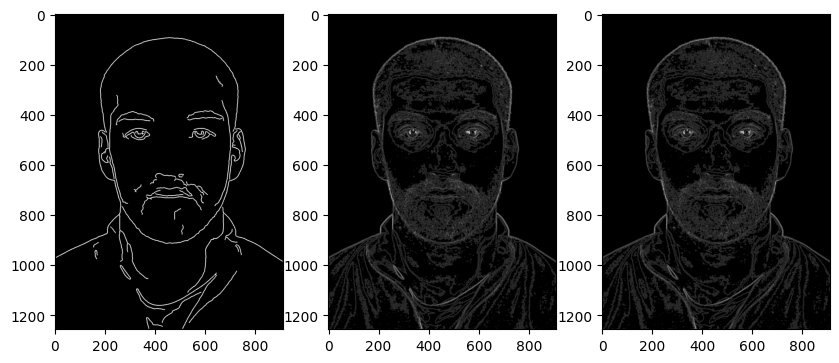

In [11]:
from skimage.morphology import dilation

# Apply dilation to the edge-detected image
dilated_quant_canny = quant_canny.apply(dilation)
dilated_quant_sobel = quant_sobel.apply(dilation)
dilated_quant_scharr = quant_scharr.apply(dilation)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 6))
dilated_quant_canny.plot(ax=ax1)
dilated_quant_sobel.plot(ax=ax2)
dilated_quant_scharr.plot(ax=ax3)

We can also save the processed stimulus as an image:



<Axes: >

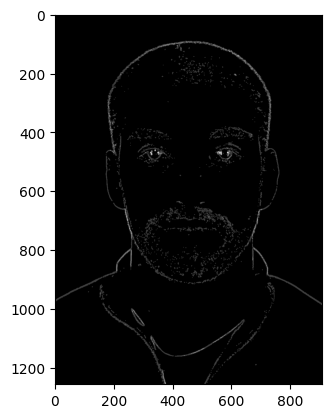

In [12]:

quantized_image = dilated_quant_scharr.apply(quantize_to_8_levels)  

quantized_image.plot()

## Using the image as input to a retinal implant

:py:class:`~pulse2percept.stimuli.ImageStimulus` can be used in
combination with any :py:meth:`~pulse2percept.implants.ProsthesisSystem`.
We just have to resize the image first so that the number of pixels in the
image matches the number of electrodes in the implant.

But let's start from the top. The first two steps are to create a model and
choose an implant:



<Axes: xlabel='x (microns)', ylabel='y (microns)'>

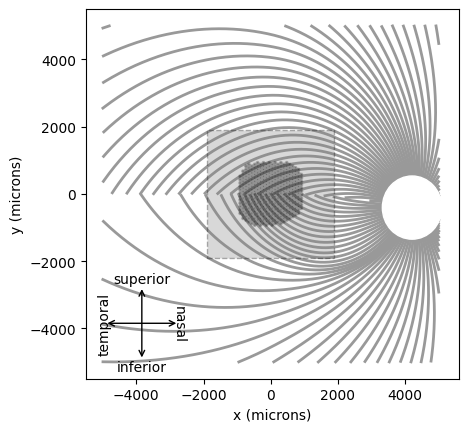

In [13]:
# Simulate only what we need (14x14 deg sampled at 0.1 deg):
model = p2p.models.AxonMapModel(xrange=(-7, 7), yrange=(-7, 7), xystep=0.1)
model.build()

from pulse2percept.implants import PRIMA
implant = PRIMA()

# Show the visual field we're simulating (dashed lines) atop the implant:
model.plot()
implant.plot()

Since :py:class:`~pulse2percept.implants.AlphaAMS` is a 2D electrode grid,
all we need to do is downscale the image to the size of the grid:



<Axes: xlabel='x (microns)', ylabel='y (microns)'>

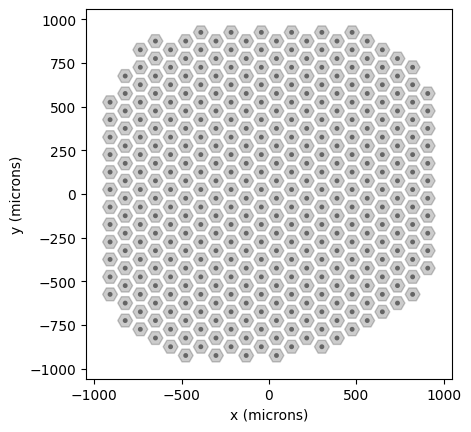

In [15]:
implant.stim = quantized_image.resize(implant.shape)  # Resize to implant size
implant.plot()

This way, the pixels of the image will be assigned to the electrodes in
row-by-row order (i.e., we don't need to specify the actual electrode names).

.. note ::

   If the implant is not a proper 2D grid, you will have to manually specify
   the input to each electrode.

   In the near future, this will be done automatically using an implant's
   ``preprocess`` method.

Then the implant can be passed to the model's
:py:meth:`~pulse2percept.models.ScoreboardModel.predict_percept` method:



In [16]:
percept_gray = model.predict_percept(implant)

.. note ::

    Because neither :py:class:`~pulse2percept.stimuli.ImageStimulus` nor
    :py:class:`~pulse2percept.models.ScoreboardModel` can handle time, the
    resulting percept will consist of a single image/frame.

To see what difference our image preprocessing makes on the quality of the
resulting percept, we can re-run the model on ``logo_dilate`` and plot the
two percepts side-by-side:



## Converting the image to a series of electrical pulses

:py:class:`~pulse2percept.stimuli.ImageStimulus` has an
:py:meth:`~pulse2percept.stimuli.ImageStimulus.encode` method
to convert an image into a series of pulse trains (i.e., into electrical
stimuli with a time component).

By default, the ``encode`` method will interpret the gray level of a pixel as
the current amplitude of a :py:class:`~pulse2percept.stimuli.BiphasicPulse`
with 0.46ms phase duration (500ms total stimulus duration). Gray levels in
the range [0, 1] will be mapped onto currents in the range [0, 50] uA:



In [17]:
# Check the implant's electrode count and shape
print(f"Implant electrodes: {implant.n_electrodes}")
print(f"Implant shape: {implant.shape}")

# The PRIMA implant has 378 active electrodes out of 19×22=418 total positions
# We need to resize to match the actual number of active electrodes
target_size = int(np.sqrt(implant.n_electrodes))  # ~19x19 ≈ 361, but we need 378
print(f"Target size approximation: {target_size}x{target_size} = {target_size**2}")

# Resize the image to a manageable size and then map to electrodes
resized_logo = quantized_image.trim().resize((19, 20))  # 19×20 = 380, close to 378
print(f"Resized logo shape: {resized_logo.shape}")
print(f"Resized logo electrodes: {len(resized_logo.electrodes)}")

# Create a stimulus with only the active electrodes from the implant
from pulse2percept.stimuli import Stimulus
electrode_names = list(implant.electrode_names)
print(f"Number of electrode names: {len(electrode_names)}")

# Take only the first 378 electrodes to match the implant
if len(resized_logo.electrodes) > implant.n_electrodes:
    # First encode the resized logo to get temporal data
    encoded_logo = resized_logo.encode()
    
    # Create a new stimulus with only the required number of electrodes
    stim_data = {}
    for i, electrode in enumerate(electrode_names):
        if i < len(encoded_logo.data):
            stim_data[electrode] = encoded_logo.data[i]
    
    final_stimulus = Stimulus(stim_data)
    print(f"Final stimulus electrodes: {len(final_stimulus.electrodes)}")
    
    # Assign directly (no encode needed - already a Stimulus object)
    implant.stim = final_stimulus
else:
    # If we have fewer electrodes, we can assign directly after encoding
    implant.stim = resized_logo.encode()

Implant electrodes: 378
Implant shape: (19, 22)
Target size approximation: 19x19 = 361
Resized logo shape: (380, 1)
Resized logo electrodes: 380
Number of electrode names: 378
Final stimulus electrodes: 378
Resized logo shape: (380, 1)
Resized logo electrodes: 380
Number of electrode names: 378
Final stimulus electrodes: 378


We can customize the range of amplitudes to be used by passing a keyword
argument; e.g. ``amp_range=(0, 20)`` to use currents in [0, 20] uA.

We can also specify our own pulse / pulse train to be used. First, we need to
create the pulse we want to use (use amplitude 1 uA). Then, we need to pass
it as an additional keyword argument; e.g.,
``pulse=BiphasicPulseTrain(10, 1, 0.2, stim_dur=200)`` to use a 10Hz
biphasic pulse train (0.2ms phase duration, overall duration 200 ms).

## Using the image as input to a spatiotemporal model

Now, if we passed the new stimulus to
:py:class:`~pulse2percept.models.ScoreboardModel`, it would simply apply the
model (in space) to every time point in the stimulus.
To get a proper temporal response, we need to extend the scoreboard model
with a proper temporal model, such as
:py:class:`~pulse2percept.models.Horsager2009Temporal`:



In [18]:
model = p2p.models.Model(spatial=p2p.models.AxonMapSpatial,
                         temporal=p2p.models.Horsager2009Temporal)

<div class="alert alert-info"><h4>Note</h4><p>You can combine any spatial model (names ending in **Spatial**) with any
   temporal model (names ending in **Temporal**).</p></div>

To make the model focus on the same visual field as above, we set ``xrange``,
``yrange``, and choose a proper ``xystep``.

The ``rho`` parameter of the scoreboard model controls how much blur we get
in the resulting percept. The value of this parameter should be set
empirically to match the quality of the vision reported behaviorally by each
implant user.
For the purpose of this tutorial, we will set it to 50um:



In [19]:
model.build(xrange=(-7, 7), yrange=(-7, 7), xystep=0.1, rho=50)

Model(ax_segments_range=(0, 50), axlambda=500, 
      axon_pickle='axons.pickle', axons_range=(-180, 180), 
      beta=3.43, dt=0.005, engine=None, eps=2.25, eye='RE', 
      grid_type='rectangular', ignore_pickle=False, 
      loc_od=(15.5, 1.5), min_ax_sensitivity=0.001, 
      n_ax_segments=500, n_axons=1000, n_gray=None, 
      n_jobs=1, n_threads=8, ndim=[2], noise=None, rho=50, 
      scheduler='threading', spatial=AxonMapSpatial, 
      tau1=0.42, tau2=45.25, tau3=26.25, 
      temporal=Horsager2009Temporal, thresh_percept=0, 
      verbose=True, vfmap=Watson2014Map(ndim=2), 
      xrange=(-7, 7), xystep=0.1, yrange=(-7, 7))

In [20]:
percept = model.predict_percept(implant)

The output of the model is a :py:class:`~pulse2percept.percepts.Percept`
object, which can be animated in IPython or Jupyter Notebook using the
:py:meth:`~pulse2percept.percepts.Percept.play` method:



In [21]:
percept.play()

You can also save the percept as a movie:



In [ ]:
percept.save('logo_percept.mp4')